In [1]:
##################
## Load Imports ##
##################
import math
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import plotting_helpers
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Set the random seed for PyTorch
seed = torch.manual_seed(1)

# 2 Bayesian Logistic Regression: Laplace Approximation

In this exercise, we will learn about approximate Bayesian inference in logistic regression. We will consider approximate inference methods: the Laplace Approximation and Variational Inference (VI). We will focus on the Laplace approximation in this exercise and save (VI) for the next one. We will use a toy dataset and do the following:

1. Compute the true posterior distribution using a numerical method.
2. Implement MAP estimation and use it to compute the MAP solution.
3. Compute the Laplace Approximation for the toy logistic regressin problem.

We first load imports and generate a 2D synthetic dataset with two different classes. Data is taken from Kevin Murphy's Machine Learning: a Probabilistic Perspective.

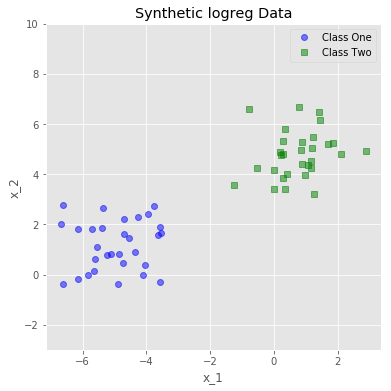

In [2]:
def logreg_synthetic_data(N=60, std1=1, std2=1.1):
    ''' Generate a binary classification dataset where the features for the two classes are
        sampled from different 2-dimensional Gaussians.
    '''
    mid_index = math.floor(N/2)
    
#   define different mean vectors for the two different classes.
    mu1 = torch.stack([torch.ones(mid_index), torch.ones(N-mid_index)*5],dim=1)
    mu2 = torch.stack([torch.ones(mid_index)*-5, torch.ones(N-mid_index)], dim=1)

#   sample features from normal distributions.
    X = torch.cat([
        torch.normal(mean=mu1, std=std1),
        torch.normal(mean=mu2, std=std2)])
    
#   class labels are in the set {0,1}.
    y = torch.ones(N)
    y[mid_index:N] = y[mid_index:N] - 1

    return X, y

X, y  = logreg_synthetic_data()

# plot the data set.
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

plotting_helpers.plot_logreg_data(ax1, X.detach().numpy(), y.detach().numpy())

## 2.1 Model Specification

The logistic regression model assumes that the outputs y are distributed as

$$p(y|w) \sim Bernoulli(\sigma(\boldsymbol{w}^\top x))$$

where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the logistic function. The probability $p(y=1) = \sigma(\boldsymbol{w}^\top x)$ is a linear function of the inputs $x$ passed through a "squash" function --- the logistic function $\sigma(z)$ in this case --- whose range is the interval $[0,1]$.

In our Bayesian logistic regression formulation, the likelihood of model is then given by,

$$p(\mathcal{D} | \boldsymbol{w})  = \prod_{n=1}^N Bernoulli(y_i | \sigma(\boldsymbol{w}^\top x_i)) = \prod_{n=1}^N \sigma(\boldsymbol{w}^\top x_i)^{y_i}(1 - \sigma(\boldsymbol{w}^\top x_i))^{(1 - y_i)}.$$

We choose a Gaussian prior just as we did in linear regression,

$$p(w) = \mathcal{N}(\boldsymbol{w} | 0, \lambda^{-1} \boldsymbol{I}),$$

where $\lambda$ is the prior precision.

In [3]:
lam = 0.01 # Prior precision

mu_prior = torch.zeros(2) # Prior Mean
Sigma_prior = torch.eye(2) / lam

prior_distribution = MultivariateNormal(mu_prior, covariance_matrix=Sigma_prior)

## 2.2 Computing the Posterior Distribution Using a Numerical Method

The Gaussian prior we have chosen is non-conjugate to the logistic likelihood function, which means that the posterior distribution is not in the same probability distribution family as the prior. In our case, this means that the posterior is not a Gaussian distribution. Non-conjugate priors are algebraically inconvinient because the posterior does not have a closed-form expression.

A straightforward way to compute the posterior distribution in this case is to compute the marginal probability
$$p( \mathcal{D}) = \int p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}) dw$$
using a numerical method. This requires evaluating the joint density $p(\mathcal{D}, \boldsymbol{w}) = p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w})$ over a large region of $\boldsymbol{w}$ space and then summing over the evaulations:
$$ \int p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}) d\boldsymbol{w} \approx \delta^{d} * \sum_{\boldsymbol{w} \in \boldsymbol{W}_{GRID}}  p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}).$$
Here $\boldsymbol{W}_{GRID}$ is a discretization of the $\boldsymbol{w}$ space into a set of weight vectors, $\delta$ is the spacing betweeen points in the discretization and $d$ is the dimensionality of $\boldsymbol{w}$. Notice that this is a simplification of the trapezoidal rule for numerical integration.

In this logistic regression example, $\boldsymbol{w}$ has only two dimensions and it is possible to perform numerical integration. However, this does not work in general; numerical integration is intractable for larger datasets.


### Your Tasks:
* Compute the posterior distribution over model parameters $w$ by implementing the normalization of the joint distribution in ```evaluate_posterior_over_grid```.
* Functions for evaluating the prior and joint distributions over $W_{GRID}$ have been provided in ```evaluate_prior_over_grid``` and ```evaluate_joint_over_grid```. You only need to normalize the posterior distribution by correctly computing the marginal probability.


In [4]:
def evaluate_prior_over_grid(W, mu_prior, Sigma_prior):
    ''' Evaluates the prior distribution's density function on a grid of values in parameter space. 
        Parameters:
            W: the grid of parameter values flattened into an array of parameter vectors
            mu_prior: The mean of the prior distribution
            Sigma_prior: The covariance of the prior distribution
    '''
    prior = stats.multivariate_normal(mean=mu_prior, cov=Sigma_prior)
    return prior.pdf(W)

def evaluate_joint_over_grid(W, mu_prior, Sigma_prior, X, y):
    ''' Evaluates the joint distribution's density function on a grid of values in parameter space. 
        Parameters:
            W: the grid of parameter values flattened into an array of parameter vectors
            mu_prior: The mean of the prior distribution
            Sigma_prior: The covariance of the prior distribution
            X: dataset features
            y: dataset labels
    '''
    X_np = X.numpy()
    y_np = y.numpy()

    f = W @ X_np.T
    log_prior = np.log(evaluate_prior_over_grid(W, mu_prior, Sigma_prior))
    log_like = np.sum(f * np.squeeze(y_np) - np.log(1+np.exp(f)), 1)
    log_joint = log_like + log_prior
    joint = np.exp(log_joint)

    return joint, log_joint

In [5]:
### TASKS BEGIN ###
def evaluate_posterior_over_grid(W, mu_prior, Sigma_prior, X, y, grid_spacing):
    ''' Evaluates the posterior distribution's density function on a grid of values in parameter space. 
        Parameters:
            W: the grid of parameter values flattened into an array of parameter vectors
            mu_prior: The mean of the prior distribution
            Sigma_prior: The covariance of the prior distribution
            X: dataset features
            y: dataset labels
            grid_spacing: the spacing between adjacent parameter vectors in the grid.
    '''
    joint, log_joint = evaluate_joint_over_grid(W, mu_prior, Sigma_prior, X, y)

    
    ### fill in your code for the log-marginal here ###
    log_marginal = 0
    
    log_post = log_joint - log_marginal
    post = np.exp(log_post)
    
    return post, log_post
### TASKS END ###

In [6]:
grid_spacing = 0.5

# Create a grid of potential values in parameter space. 
w1, w2 = np.mgrid[-30:30:grid_spacing, -30:30:grid_spacing]
# Compute all combinations of w1 and w2 values from the grid.  
W_grid = np.squeeze(np.dstack((w1.reshape(w1.size), w2.reshape(w2.size))))

prior_density = evaluate_prior_over_grid(W_grid, mu_prior, Sigma_prior)
joint_density, _ = evaluate_joint_over_grid(W_grid, mu_prior, Sigma_prior, X, y)
posterior_density, _ = evaluate_posterior_over_grid(W_grid, mu_prior, Sigma_prior, X, y, grid_spacing)

# Reshape the densities back into a grid.
prior_density = prior_density.reshape((w1.shape[0], w2.shape[0]))
joint_density = joint_density.reshape((w1.shape[0], w2.shape[0]))
posterior_density = posterior_density.reshape((w1.shape[0], w2.shape[0]))

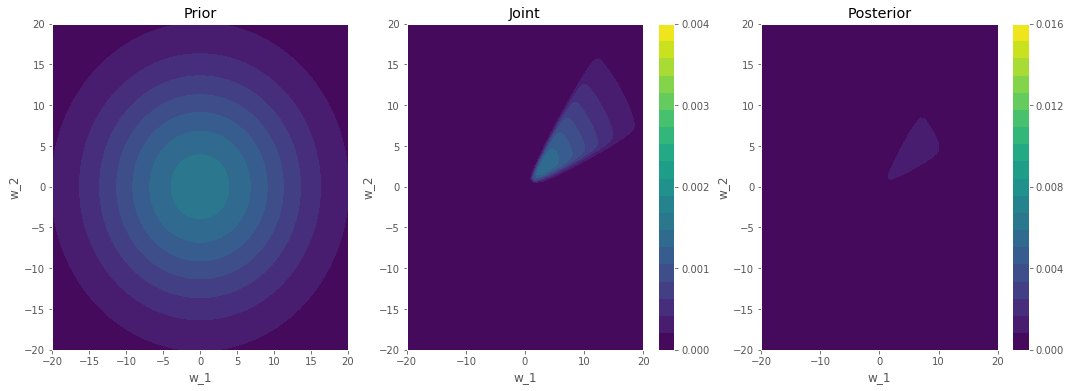

In [7]:
### Visualizing the prior, joint and posterior distributions ###
## IMPORTANT: The scale for the prior/joint countour plots is only 1/4 of the posterior countour's scale. ##

plotting_helpers.la_visualize_prior_joint_posterior(w1,w2,prior_density,joint_density,posterior_density)

## 2.3 The Laplace Approximation using MAP Estimation

### 2.3.1 MAP Estimation

We will now learn about the Laplace Approximation, which uses the MAP estimate to compute an approximation to the posterior distribution. Recall that MAP estimation computes the maximum of the joint distribution 

$$\mathcal{L}_{MAP} = \log(p(\mathcal{D} | \boldsymbol{w}) + \log(p(\boldsymbol{w})).$$

This is achieved by minimizing the negative of the MAP objective:

$$ \boldsymbol{w}_{MAP} = argmin_{\boldsymbol{w}} - \mathcal{L}_{MAP} argmin_{\boldsymbol{w}} - \log(p(\mathcal{D} | \boldsymbol{w}) - \log(p(\boldsymbol{w}))$$

In the following, we provide a training loop for minimizing the MAP objective and and implementation of the log-likelihood along with its gradients.

### Your Tasks:
* Implement ```log_prior``` by filling in the gradient of the negative log-prior.
* Implement ```gradient_descent``` by filling in the update step for the model parameters $w$.
* Remember that the multivariate Gaussian density is

$$ p(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}, \Sigma) = \frac{1}{(|2\pi \Sigma|)^{\frac{1}{2}}} \exp\left(-\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})\right) $$

In [8]:
### TASKS BEGIN ###
def log_prior(lam, w):
    ''' Computes and returns the value and gradient (wrt w) of the log-prior distribution 
        evaluated at w. 
        Parameters:
            lam: precision of the prior distribution
            w: parameter vector
    '''
    nlp = prior_distribution.log_prob(w)
    
    ### Implement gradient of the log-prior here ###
    g = 0 
    
    return nlp, g

def gradient_descent(lam, alpha, w, g):
    ''' Does one iteration of gradient descent for the model parameters (w).
        Parameters:
            lam: precision of the prior distribution
            alpha: step size
            w: current model parameters
            g: gradient of the MAP objective wrt w
    '''
    
    ### update w using the gradient here ###
    
    return w
### TASKS END ###

In [9]:
def log_likelihood(X, y, w):
    ''' Computes and returns the value, gradient, and Hessian of the negative log-likelihood of the data
        (X,y) evaluated at w.
        Parameters:
            X: dataset features
            y: dataset labels
    '''
    (N, _) = X.size()
    logits = torch.mv(X, w)
    probs = torch.sigmoid(logits).clamp(min=1e-6, max=1-1e-6)
    nll = -1 * torch.sum(y * torch.log(probs) + (1 - y) * torch.log(1 - probs))

    g = torch.mv(X.t(), (probs - y))
    H = torch.mm(torch.mm(X.t(), torch.diag((probs * (1 - probs)))), X)

    return nll, g, H

    

def train(lam, max_iters, alpha, X, y, w):
    ''' Basic training loop for MAP estimation.
        Parameters:
            lam: precision of the prior distribution
            max_iters: the number of iterations of gradient descent to run
            alpha: the gradient descent step size
            X: dataset features
            y: dataset labels
            w: an initial value for the model parameters
    ''' 
    objective_history = []
    w_history = w.unsqueeze(0)
    for i in range(max_iters):
        # gradient and Hessian of the negative log-likelihood
        nll, g_nll, H_nll = log_likelihood(X, y, w)
        # gradient of the negative log-w
        nlp, g_prior = log_prior(lam, w)
        
        g = g_nll + g_prior
        w = gradient_descent(lam, alpha, w, g)
        
        # record the objective and parameters for visualization
        objective_history.append(nll + nlp)
        w_history = torch.cat([w_history, w.unsqueeze(0)], dim=0)
        
    return w, objective_history, w_history


# Compute the MAP Estimate
max_iters = 1000
alpha = 0.01
w = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
w_map, objective_history, w_history = train(lam, max_iters, alpha, X, y, w)

The MAP estimate is: [0. 0.]


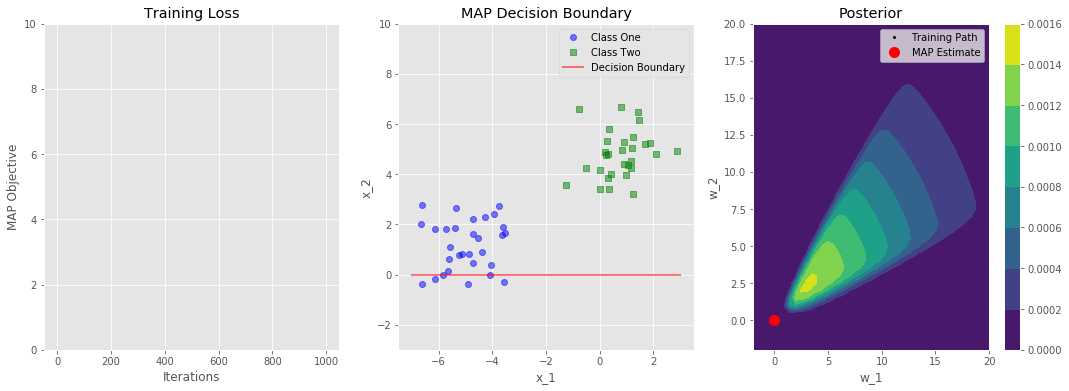

In [10]:
### Visualize the MAP Estiamte ###
plotting_helpers.visualize_MAP_estimate(objective_history, w_history, max_iters, w1, w2, posterior_density, w_map, X, y)

### 2.3.2 The Laplace Approximation

We now consider computing the Laplace Approximation to the posterior distribution for the synthetic logistic regression problem. This is easy to do since we have already found MAP estimate of our model parameters, $\boldsymbol{w}_{MAP}$, using gradient descent.

Recall that the Laplace approximation is found by a second order Taylor series approximation of the log-posterior distribution at the MAP estimate:

$$ \log p(\boldsymbol{w} | \mathcal{D}) \approx \log p(\boldsymbol{w}_{MAP} | \mathcal{D}) + (\boldsymbol{w} - \boldsymbol{w}_{MAP})^\top \nabla_{\boldsymbol{w}} \log p(\boldsymbol{w}_{MAP} | \mathcal{D}) +  (\boldsymbol{w} - \boldsymbol{w}_{MAP})^\top \nabla_{\boldsymbol{w}^2}^2 \log p(\boldsymbol{w}_{MAP} | \mathcal{D})(\boldsymbol{w} - \boldsymbol{w}_{MAP}) $$


### Your Tasks:
* Complete the implementation of ```compute_laplace_approximation``` by filling in the computations for the mean and covariance of the approximation.
* Remember that ```log_likelihood``` also computes the Hessian of $- \log p(\mathcal{D}|\boldsymbol{w})$.

In [11]:
### TASKS BEGIN ###
def compute_laplace_approximation(lam, X, y, w_map):
    ''' Computes the mean and covariance of the Laplace approximation for logistic regression.
        Parameters:
            lam: precision of the prior distribution
            max_iters: the number of iterations of gradient descent to run
            alpha: the gradient descent step size
            X: dataset features
            y: dataset labels
    '''
    
    ### fill in computation of mean and covariance of the Laplace approximation here ##
    
    mu = w_map
    Sigma = torch.eye(2, requires_grad=True) / lam

    return mu, Sigma
### TASKS END ###


mu_la, Sigma_la = compute_laplace_approximation(lam, X, y, w_map)

print('The Laplace Approximation is: \n mean: \n', mu_la.detach().numpy(), '\n covariance: \n', Sigma_la.detach().numpy())

The Laplace Approximation is: 
 mean: 
 [0. 0.] 
 covariance: 
 [[100.   0.]
 [  0. 100.]]


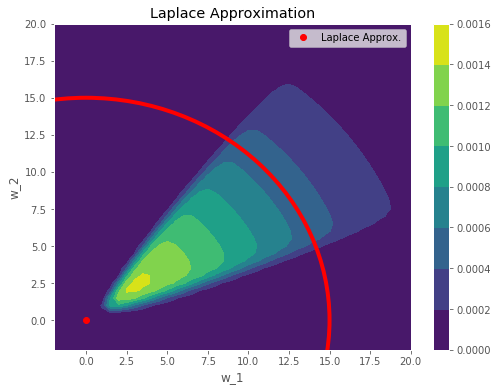

In [12]:
### Visualizing the Laplace Approximation ###
plotting_helpers.visualize_laplace_approximation(w1,w2,posterior_density,mu_la,Sigma_la)
